<a href="https://colab.research.google.com/github/kellydingzx/ecg_notebooks/blob/main/af_detector2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [ ]:
!wget -r -N -c -np https://physionet.org/files/nsrdb/1.0.0/

In [ ]:
import pip
import os

try:
    import wfdb
except ModuleNotFoundError:
    pip.main(['install', "wfdb"])
    import wfdb

import numpy as np
import matplotlib.pyplot as plt 

In [ ]:
!pip install neurokit2

In [ ]:
import sys
import neurokit2 as nk2
import readin
import display

## Functions

In [220]:
def get_peaks(sample_path, leads, fs):
    signal, rest = wfdb.rdsamp(sample_path, sampfrom=0, sampto=60*60*fs*2, 
                                channel_names = leads)
    cleaned = nk2.ecg_clean(signal, fs, method='neurokit2')
    signals, info = nk2.ecg_peaks(cleaned, fs, method='neurokit2')

    return info["ECG_R_Peaks"]

def get_rr_drr(peaks, fs):
    rr_intervals = np.diff(peaks)
    rr_intervals = np.divide(rr_intervals, fs)
    d_rr = np.diff(rr_intervals)

    return rr_intervals[1:], d_rr

In [221]:
def get_nec(plot_x, plot_y):
    x_min, x_max = min(plot_x), max(plot_x)
    y_min, y_max = min(plot_y), max(plot_y)

    x_min = 200 if x_min<200 else x_min
    y_min = -500 if y_min<-500 else y_min
    x_max = 2000 if x_max>2000 else x_max
    y_max = 1000 if y_max>1000 else y_max

    x_start, x_fin = (x_min//25-1)*25 , (x_max//25+1)*25
    y_start, y_fin = (y_min//25-1)*25, (y_max//25+1)*25

        
    nec = 0
    for x_i in range(int(x_start), int(x_fin), 25):
        for y_i in range(int(y_start), int(y_fin), 25):
            x_ind = np.where(np.logical_and(plot_x>=x_i, plot_x<x_i+25))[0]
            y_ind = np.where(np.logical_and(plot_y>=y_i, plot_y<y_i+25))[0]
            in_box = np.intersect1d(x_ind, y_ind)
            if len(in_box)>0: nec+=1
    
    return nec

In [222]:
def full_nec(example_path, leads, fs, window_size):

    peak_idx = get_peaks(example_path, leads, fs)
    annots = wfdb.rdann(example_path, 'atr', sampfrom=0, sampto=None)
    af_idx = annots.sample

    nec_records = {}
    for i in range(0, len(peak_idx)-window_size, window_size+1):
        peak_chosen = peak_idx[i:i+window_size+1]
        rr, drr = get_rr_drr(peak_chosen, fs)
        plot_x = rr*1000
        plot_y = drr*1000
        nec = get_nec(plot_x, plot_y)
        segment = (peak_chosen[0], peak_chosen[-1])
        nec_records[segment] = nec
    
    return nec_records, af_idx

In [223]:
def get_nsr(nec_records, opti):
   counts = 0
   for seg, nec in nec_records.items():
     if nec > opti:
       counts += 1
   return counts

In [224]:
def get_results(nec_records, af_idx, opti):
    true_pos, true_neg, false_pos, false_neg = 0,0,0,0
    for seg, nec in nec_records.items():
        found = np.where(np.logical_and(af_idx>=seg[0],af_idx<=seg[1]))[0]
        if nec > opti and len(found) != 0:
            true_pos += 1
        elif nec <opti and len(found) == 0:
            true_neg +=1
        elif nec<opti and len(found)!=0:
            false_neg +=1
        elif nec>opti and len(found) == 0:
            false_pos +=1
    return true_pos, true_neg, false_pos, false_neg

In [225]:
def get_stats(true_pos, true_neg, false_pos, false_neg):
    sensitivity = None if true_pos+false_neg == 0 else true_pos/(true_pos+false_neg)
    specificity = true_neg/(true_neg+false_pos)
    ppv = true_pos/(true_pos+false_pos)
    f1 = None if sensitivity == None or ppv==0 else 2*ppv*sensitivity/(ppv+sensitivity)
    return sensitivity, specificity, ppv, f1

In [226]:
def af_analyse(example_path, leads, fs, window_size, opti):
    nec_records, af_idx = full_nec(example_path, leads, fs, window_size)
    tp, tn, fp, fn = get_results(nec_records, af_idx, opti)
    sen, spe, ppv, f1 = get_stats(tp, tn, fp, fn)
    return sen, spe, nec_records

In [227]:
def nsr_analyse(example_path, leads, fs, window_size, opti):
    nec_records, _ = full_nec(example_path, leads, fs, window_size)
    counts = get_nsr(nec_records, opti)
    return counts

## Example

In [197]:
example_path = '/content/physionet.org/files/afdb/1.0.0/16265'
leads = ['ECG1']
fs=128

# sen, spe, nec_records = af_analyse(example_path, leads, fs, 32)

In [ ]:
peaks = get_peaks(example_path, leads, fs)

In [ ]:
peaks

array([    150,     394,     643, ..., 9204964, 9205183, 9205619])

In [ ]:
rr, drr = get_rr_drr(peaks, fs)

In [ ]:
rr*1000

array([ 996., 1044.,  992., ...,  900.,  876., 1744.])

In [ ]:
len(peaks)

38083

In [ ]:
len(rr[38049:38082])

32

In [ ]:
nec_records, af_idx = full_nec(example_path, leads, fs, 64)

In [ ]:
tp, tn, fp, fn = get_results(nec_records, af_idx, 40)

In [ ]:
tp, tn, fp, fn

(1, 569, 5, 9)

In [ ]:
get_stats(tp, tn, fp, fn)

(0.1, 0.9912891986062717, 0.16666666666666666, 0.125)

In [208]:
import os
arr = os.listdir('/content/physionet.org/files/nsrdb/1.0.0/')

sample_ids = []
for file in arr:
    if '.atr' in file:
        sample_ids.append(file[:5])

# sample_ids.remove('03665')
# sample_ids.remove('00735')
# sample_ids.remove('04043')

all_ids = list(set(sample_ids)) 

In [ ]:
result = {}
opti = {32:23, 64:40, 128:65}
for win in [32, 64, 128]:
  op = opti[win]
  for lead in ['ECG1', 'ECG2']:
    counts = []
    for id in all_ids:
        count = nsr_analyse('/content/physionet.org/files/nsrdb/1.0.0/'+id, [lead], 250, win, op)
        counts.append(count)
    print(lead + ' '+str(win))
    result[lead + ' '+str(win)] = counts

ECG1 32
ECG2 32
ECG1 64


In [ ]:
np.mean(res_sen[2:]), np.mean(res_spe[2:])

(0.6548440813572391, 0.6161593311969538)

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.

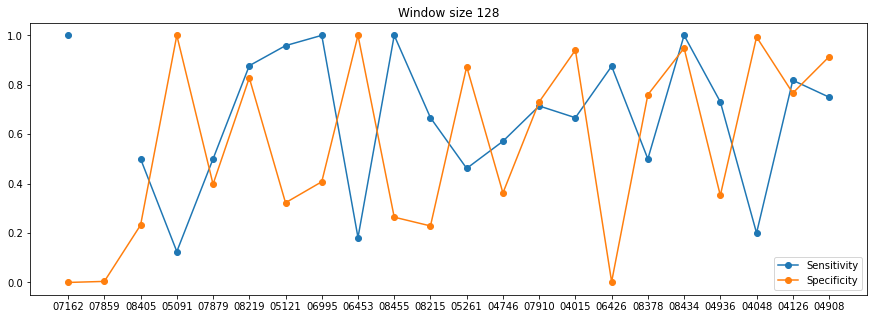

In [ ]:
plt.figure(figsize=(15,5))
plt.title('Window size 128')
plt.plot(all_ids, res_sen, linestyle='-', marker="o", label='Sensitivity')
plt.plot(all_ids, res_spe, linestyle='-', marker="o", label='Specificity')
plt.legend()

## Demo Graphs

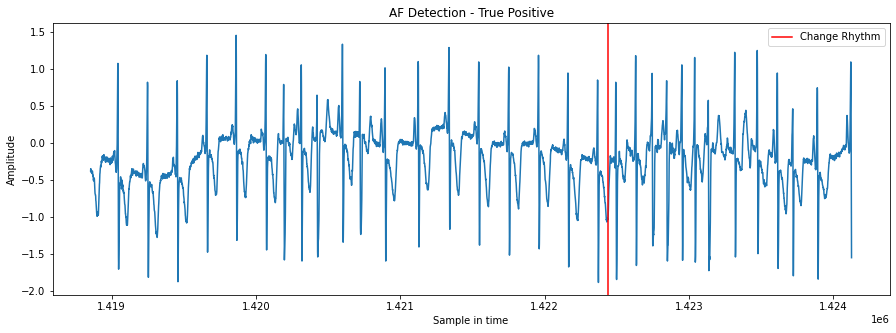

In [ ]:
# True positive demo
interval = None
occur = None
for seg, nec in nec_records.items():
    found = np.where(np.logical_and(af_idx>=seg[0],af_idx<=seg[1]))[0]
    if nec > 23 and len(found) != 0:
        interval = seg
        occur = af_idx[found[0]]

example_samples, _= readin.get_data(example_path, leads, interval[0], interval[1])
plt.figure(figsize=(15,5))
plt.title('AF Detection - True Positive')
plt.xlabel('Sample in time')
plt.ylabel('Amplitude')
plt.plot(range(interval[0], interval[1]),example_samples)
plt.axvline(x=occur, color='r', label='Change Rhythm')
plt.legend()

WARNING: No handles with labels found to put in legend.


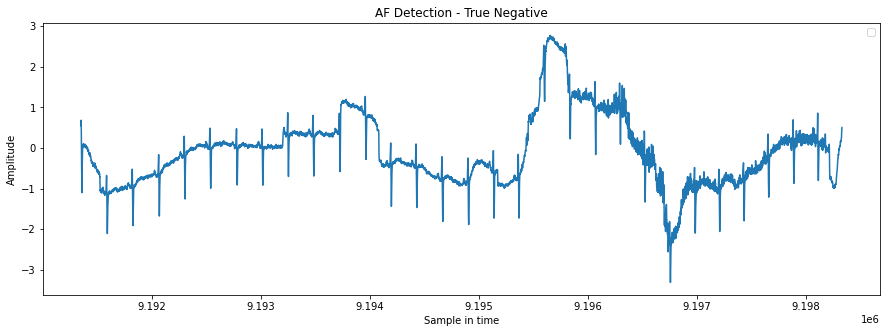

In [ ]:
# True negative demo
interval = None

for seg, nec in nec_records.items():
    found = np.where(np.logical_and(af_idx>=seg[0],af_idx<=seg[1]))[0]
    if nec < 23 and len(found) == 0:
        interval = seg

example_samples, _= readin.get_data(example_path, leads, interval[0], interval[1])
plt.figure(figsize=(15,5))
plt.title('AF Detection - True Negative')
plt.xlabel('Sample in time')
plt.ylabel('Amplitude')
plt.plot(range(interval[0], interval[1]),example_samples)

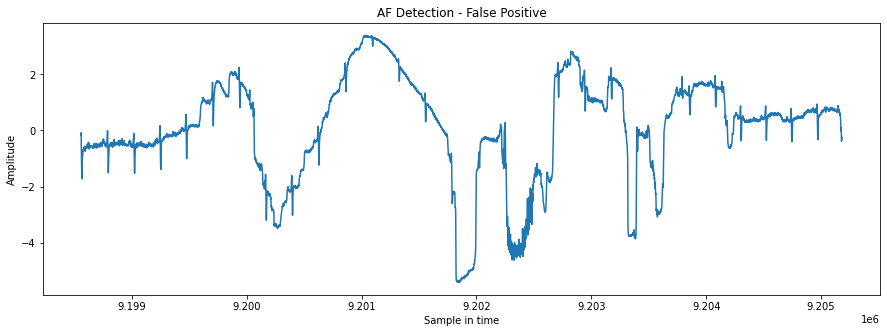

In [ ]:
# False positive demo
interval = None
for seg, nec in nec_records.items():
    found = np.where(np.logical_and(af_idx>=seg[0],af_idx<=seg[1]))[0]
    if nec > 23 and len(found) == 0:
        interval = seg

example_samples, _= readin.get_data(example_path, leads, interval[0], interval[1])
plt.figure(figsize=(15,5))
plt.title('AF Detection - False Positive')
plt.xlabel('Sample in time')
plt.ylabel('Amplitude')
plt.plot(range(interval[0], interval[1]),example_samples)

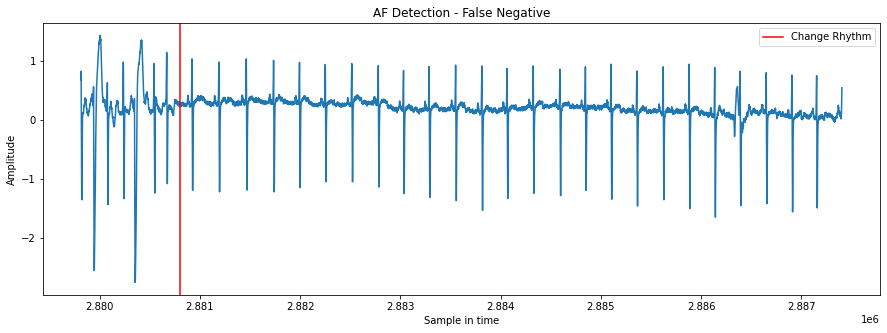

In [ ]:
# True positive demo
interval = None
occur = None
for seg, nec in nec_records.items():
    found = np.where(np.logical_and(af_idx>=seg[0],af_idx<=seg[1]))[0]
    if nec < 23 and len(found) != 0:
        interval = seg
        occur = af_idx[found[0]]

example_samples, _= readin.get_data(example_path, leads, interval[0], interval[1])
plt.figure(figsize=(15,5))
plt.title('AF Detection - False Negative')
plt.xlabel('Sample in time')
plt.ylabel('Amplitude')
plt.plot(range(interval[0], interval[1]),example_samples)
plt.axvline(x=occur, color='r', label='Change Rhythm')
plt.legend()